In [1]:
%matplotlib inline

# Linear Models and PyMC3

So far we have covered the tools we need for basic parameter estimation when we have a single unknown parameter. There is a lot you can do with just this information, but the real work horse of statistical modeling is linear models.

In [2]:
from context import src
from src import customer as cust
from src import product as prod
from src import experiment as exp
from src import messy_experiment as messy_exp

import pymc3 as pm
import arviz as az

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import expit as logistic

## Revisiting the Toothbrushes as a linear model

In [3]:
toothbrush = prod.Product(name="alright brush",
                          price=4.99,
                          quality=3.9)

luxury_toothbrush = prod.Product(name="luxury toothbrush",
                                 price=7.99,
                                 quality=4.8)

toothbrush_ab_test = exp.Experiment(toothbrush,luxury_toothbrush)
n_samples = 100
experiment_results = toothbrush_ab_test.show_to_customers(n_samples)

In [4]:
purchased = np.concatenate((experiment_results.a_purchased.astype(int),
                            experiment_results.b_purchased.astype(int)))
is_luxury = np.concatenate((np.zeros(n_samples),
                            np.ones(n_samples)))
ab_test_data = pd.DataFrame({
    'purchased' : purchased,
    'is_luxury' : is_luxury
})

In [5]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('purchased ~ 1 + is_luxury',
                            ab_test_data,
                            family=pm.glm.families.Binomial())
    ab_trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [is_luxury, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1500.64draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e68ce80>,
      dtype=object)

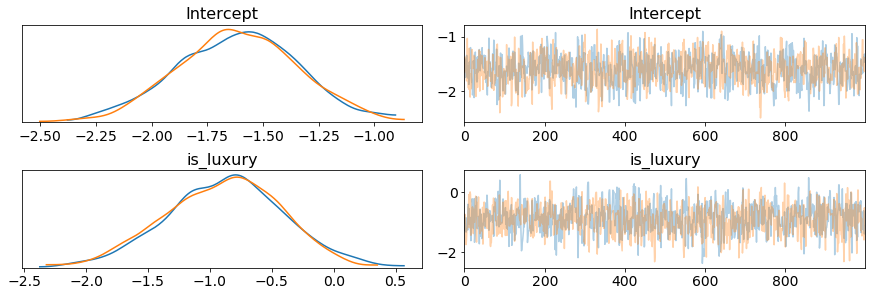

In [6]:
pm.traceplot(ab_trace)

Discuss what this mean in the model...

In [7]:
lo_is_luxury = ab_trace.get_values('is_luxury')

print(sum(lo_is_luxury > 0)/len(lo_is_luxury))

0.0255


In [8]:
lo_regular = ab_trace.get_values('Intercept')

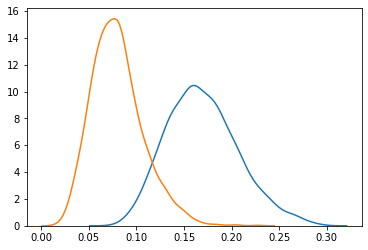

In [9]:
sns.distplot(logistic(lo_regular),hist=False)
sns.distplot(logistic(lo_is_luxury + lo_regular),hist=False)

Compare this with just using our Beta distribution estimates...

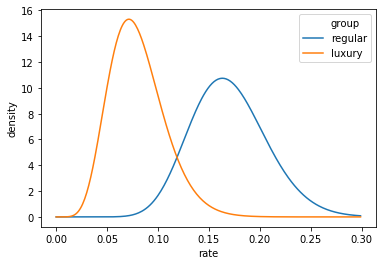

In [10]:
alpha_a = sum(experiment_results.a_purchased)
beta_a = n_samples - alpha_a 
a_beta_dist = stats.beta(alpha_a,beta_a)

alpha_b = sum(experiment_results.b_purchased)
beta_b = n_samples - alpha_b 
b_beta_dist = stats.beta(alpha_b,beta_b)
rates = np.arange(0,0.3,0.001)
plot_df = pd.DataFrame({
    'density':np.concatenate((a_beta_dist.pdf(rates),
                              b_beta_dist.pdf(rates))),
    'rate': np.concatenate((rates,rates)),
    'group':['regular']*len(rates) + ['luxury']*len(rates)
})
sns.lineplot(x='rate',
             y='density',
             hue='group',
             data=plot_df)

nearly the same result!

but why would we care? 

Using a linear model gives us the same result, but also makes it much easier for us to extend our solution to more complicated issues.

## More complicated issues!

Now let's suppose we have a situation where we have two other products that we want to sell:

In [11]:
very_nice_pencil = prod.Product(name="Very nice pencil",
                                price=4.99,
                                quality=4.9)
deluxe_pencil = prod.Product(name="Deluxe pencil",
                             price=4.25,
                             quality=4.8)

We're going to run another experiment testing this values, but in this case we'll simulate when we don't design our experiment quite right:

In [12]:
pencil_test = messy_exp.MessyExperiment(very_nice_pencil,
                                        deluxe_pencil)

We'll run this test for a bunch of people so we can get some pretty good results

In [13]:
n_samples = 2500
test_results = pencil_test.show_to_customers(n_samples)

In [14]:
sum(test_results.a_purchased)/n_samples

array([0.194])

In [15]:
sum(test_results.b_purchased)/n_samples

array([0.162])

In [16]:
purchased = np.concatenate((test_results.a_purchased.astype(int),
                            test_results.b_purchased.astype(int)))
is_deluxe = np.concatenate((np.zeros(n_samples),
                            np.ones(n_samples)))
pencil_test_data = pd.DataFrame({
    'purchased' : purchased,
    'is_deluxe' : is_deluxe
})

with pm.Model() as pencil_test_model:
    pm.glm.GLM.from_formula('purchased ~ 1 + is_deluxe',
                            pencil_test_data,
                            family=pm.glm.families.Binomial())
    pencil_test_trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [is_deluxe, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 478.45draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121583d30>,
      dtype=object)

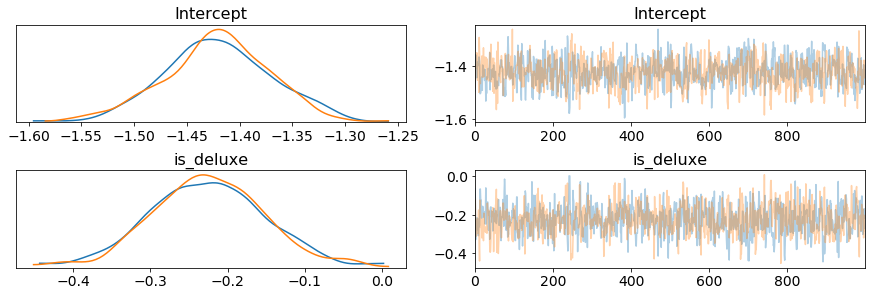

In [17]:
pm.traceplot(pencil_test_trace)

In [18]:
is_deluxe_samples = pencil_test_trace.get_values("is_deluxe")
sum(is_deluxe_samples < 0)/len(is_deluxe_samples)

0.998

Both of these pencils sold at a pretty low rate, which isn't surprsiing because they're pretty expensive. What is surprising is that it look like the `deluxe_pencil` sold for a much lower rate than the `very_nice_pencil`, even though both products are pretty much the same.

If we take a peak at our data we can get an idea of what's happening:

In [19]:
test_results.a_customer.head(10)

0     student
1    customer
2    customer
3    customer
4    customer
5    customer
6    customer
7    customer
8    customer
9    customer
Name: a_customer, dtype: object

In [20]:
test_results.b_customer.head(10)

0     student
1    customer
2    customer
3    customer
4    customer
5     student
6     student
7    customer
8     student
9     student
Name: b_customer, dtype: object

There were students in these experiments! And if we look at the two experiment groups we can see that the count is different:

In [21]:
sum(test_results.a_customer == "student")

243

In [22]:
sum(test_results.b_customer == "student")

995

The b group go exposed to much more students than the a group! Could this explain what happened? It's reasonable to assume that students might have a lower threshold for the price they are willing to purchase a pen for

In [23]:
pencil_test_data['is_student'] = np.concatenate(
    (test_results.a_customer ==  "student",
     test_results.b_customer == "student")).astype(int)

In [24]:
pencil_test_data[pencil_test_data.is_student == 1].purchased.sum()

8

In [25]:
with pm.Model() as pencil_test_student_model:
    pm.glm.GLM.from_formula('purchased ~ 1 + is_deluxe + is_student',
                            pencil_test_data,
                            family=pm.glm.families.Binomial())
    pencil_test_student_trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [is_student, is_deluxe, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 352.06draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11dcc29e8>,
      dtype=object)

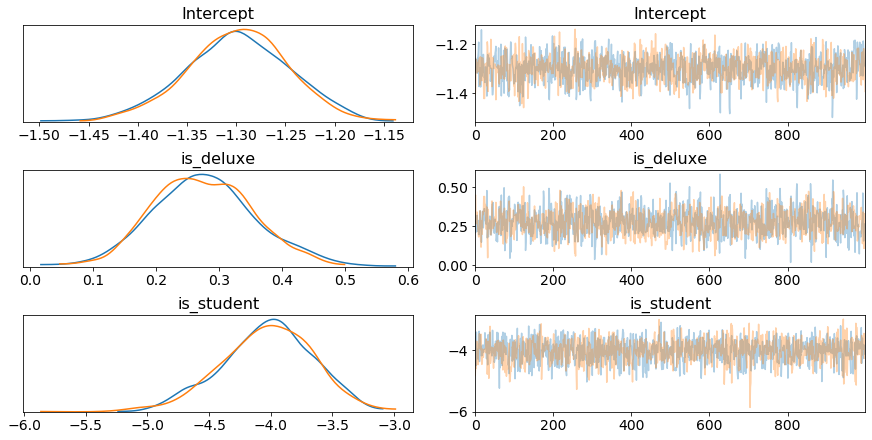

In [26]:
pm.traceplot(pencil_test_student_trace)